In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import math

RESHAPED = 1
NB_CLASSES = 1
DROPOUT = 0.3
N_HIDDEN = 512
BATCH_SIZE = 15
EPOCHS = 17
VERBOSE = 1
VALIDATION_SPLIT = 0.2

TRANSFORMATION = 3

DATA_URL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
LABEL_COLUMN = 'total_deaths'
    
file_path = tf.keras.utils.get_file("owid-covid-data.csv", DATA_URL)

SELECT_COLUMNS = ['iso_code', 'total_cases', 'total_deaths']
DEFAULTS = ['', 0.0, 0.0]

def apply_transformation(original_value):
    return (original_value/100000)**TRANSFORMATION

def get_dataset(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=1, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      shuffle=True,
      **kwargs)
    return dataset

covid_dataset = get_dataset(file_path, select_columns=SELECT_COLUMNS, column_defaults = DEFAULTS)
            
def convert_to_train_test_data(dataset, test_percent = 0.05):
    total_deaths = []
    transformed_total_cases = []
    total_cases = []
    for independent, dependent in dataset.as_numpy_iterator():
        if independent.get('iso_code')[0] == b'USA':
            total_deaths.append(dependent[0])
            transformed_total_cases.append([apply_transformation(independent.get('total_cases')[0])])
            total_cases.append([independent.get('total_cases')[0]])
    testRecordCount = int(round(test_percent*len(total_deaths)))
    return transformed_total_cases[testRecordCount:], total_cases[testRecordCount:], total_deaths[testRecordCount:], transformed_total_cases[:testRecordCount], total_cases[:testRecordCount], total_deaths[:testRecordCount]
    
x_train_transformed, x_train, y_train, x_test_transformed, x_test, y_test = convert_to_train_test_data(covid_dataset, test_percent=0.05)


features = ['total_cases']

def create_model(hidden_layers, input_shape, dropout, output_classes):
    opt = keras.optimizers.RMSprop(learning_rate=0.001)

    model = tf.keras.models.Sequential()
    model.add(keras.layers.Dense(hidden_layers, input_shape=(input_shape,), name='input_dense_layer',activation='relu'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(hidden_layers, name='hidden_dense_layer',activation='relu'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(output_classes, name='output_dense_layer'))
    
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    
    return model

Train on 86 samples, validate on 22 samples
Epoch 1/17
86/86 [==============================] - 1s 14ms/sample - loss: 130172913.9244 - accuracy: 0.5581 - val_loss: 91976189.1818 - val_accuracy: 0.0000e+00
Epoch 2/17
86/86 [==============================] - 0s 994us/sample - loss: 125230524.6163 - accuracy: 0.0465 - val_loss: 88762570.5909 - val_accuracy: 0.0000e+00
Epoch 3/17
86/86 [==============================] - 0s 942us/sample - loss: 118982926.2326 - accuracy: 0.0116 - val_loss: 84397131.6818 - val_accuracy: 0.0000e+00
Epoch 4/17
86/86 [==============================] - 0s 962us/sample - loss: 111114079.2729 - accuracy: 0.0116 - val_loss: 79889811.9091 - val_accuracy: 0.0000e+00
Epoch 5/17
86/86 [==============================] - 0s 843us/sample - loss: 103357614.4186 - accuracy: 0.0116 - val_loss: 74442597.5000 - val_accuracy: 0.0000e+00
Epoch 6/17
86/86 [==============================] - 0s 914us/sample - loss: 94328265.9767 - accuracy: 0.0116 - val_loss: 68628642.4545 - val_a

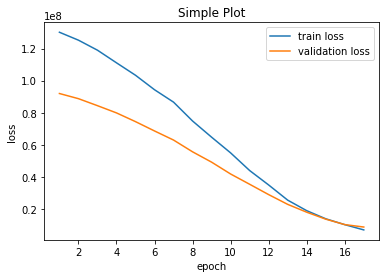

In [2]:
model = create_model(N_HIDDEN, RESHAPED, DROPOUT, NB_CLASSES)

history = model.fit(np.array(x_train_transformed), np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

model.save('saved_models/COVID_19/1')

test_loss, test_acc = model.evaluate(np.array(x_test_transformed), np.array(y_test))
print()
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(validation_loss)+1)

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(epochs, train_loss, label='train loss')
ax.plot(epochs, validation_loss, label='validation loss')
ax.set_xlabel('epoch')  # Add an x-label to the axes.
ax.set_ylabel('loss')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend() 


In [4]:
CASE_COUNT = 1000000
FUTURE_CASES = [CASE_COUNT]
FUTURE_CASES_TANSFORMED = [apply_transformation(CASE_COUNT)]
FUTURE_PREDICTION = []

print(FUTURE_CASES_TANSFORMED)

pred_deaths = model.predict(FUTURE_CASES_TANSFORMED)

for deaths in pred_deaths:
    print("deaths:", deaths)

[1000.0]
deaths: [89327.48]
